#### Quiero usar el codigo vpfnew (sacado de testing_alternativewaystoVPF) y calcular varias RVPFs leyendo simus Quijote
#### Esto eventualmente irá a un script

In [9]:
def read_quijote(snapdir,snapnum):
    """
    Returns array with Halo positions in Mpc/h
    """
    #import numpy as np
    #import readgadget
    import readfof

    #-----------
    # Read data from Quijote
    #-----------
    #
    # snapdir = '/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/fiducial/0/' #folder hosting the catalogue
    # snapnum = 4   
    # get the name of the corresponding snapshot
    # snapshot = '/home/fdavilakurban/mnt/clemente/quijote/Snapshots/fiducial/0/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

    # # read the redshift, boxsize, cosmology...etc in the header
    # header   = readgadget.header(snapshot)
    # BoxSize  = header.boxsize/1e3  #Mpc/h
    # #Nall     = header.nall         #Total number of particles
    # #Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
    # #Omega_m  = header.omega_m      #value of Omega_m
    # #Omega_l  = header.omega_l      #value of Omega_l
    # #h        = header.hubble       #value of h
    # redshift = header.redshift     #redshift of the snapshot
    # #Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

    # print('BoxSize = %.3f Mpc/h'%BoxSize)
    # #print('Number of particles in the snapshot:',Nall)
    # #print('Omega_m = %.3f'%Omega_m)
    # #print('Omega_l = %.3f'%Omega_l)
    # #print('h = %.3f'%h)
    # print('redshift = %.1f'%redshift)

    # read the halo catalogue
    FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                            swap=False, SFR=False, read_IDs=False)
    # get the properties of the halos
    return FoF.GroupPos/1e3  #Halo positions in Mpc/h

def delta_P0(P0,Nran):
    """Calculates error for P0 as derived in Colombi et al 1995
    Args:

        P0(numpy array): value(s) of P0
        Nran(numpy array): number of volume samples in the data

    Returns:
        aray: uncertainty of P0
    """

    import numpy as np
    return np.sqrt(P0*(1-P0)/Nran)

def delta_chi(chi,P0,P0err,N_mean,N_mean_std):
    """Calculates error for chi as derived in Colombi et al 1995 (Fry et al 2013)
    Args:

        chi(numpy array): value(s) of chi
        P0(numpy array): value(s) of P0
        P0err (numpy array): delta P0
        N_mean(numpy array): mean number of objects in volume(r)
        N_mean_std(numpy array): uncertainty of N_mean calculated with JK resampling

    Returns:
        array: uncertainty of chi
    """
    import numpy as np

    return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)

def vpf_new(rmin,rmax,rbins,njk,nsph,BoxSize,gxs,verbose=True):

    from scipy import spatial
    from cicTools import delta_chi, delta_P0, perrep_array

    # Basic Parameters
    #rmin, rmax = 3., 20. #Mpc
    #rbins = 10
    rs = np.geomspace(rmin,rmax,rbins)
    lbox = BoxSize

    # Jackknife Parameters
    njk = 10 #N. of Jackknifes
    jackk_bins = np.linspace(0,lbox,njk+1)

    newgxs = perrep_array(gxs,lbox,rmax)

    data_tree = spatial.cKDTree(newgxs)

    # Probing Spheres
    nsph = 100000
    sph = lbox*np.random.rand(nsph,3)

    # Calculations
    N_mean_jk = np.zeros((njk,rbins))
    #N_var_jk = np.zeros((njk,rbins))
    P0_jk = np.zeros((njk,rbins))
    xi_jk = np.zeros((njk,rbins))

    sph = lbox*np.random.rand(njk,nsph,3)


    for i in range(njk):
        if verbose==True: print(i,'/',njk,'jk')
        mask2 = (sph[i][:,0] < jackk_bins[i+1])
        mask1 = (sph[i][:,0] > jackk_bins[i])        
        mask_inv = np.logical_and(mask1,mask2)

        mask = np.invert(mask_inv)
        sph_yes = sph[i][mask,:]
        
        for j in range(rbins):
            ngal = data_tree.query_ball_point(sph_yes,rs[j],return_length=True)

            P0_jk[i][j] = len(np.where(ngal==0)[0])/len(sph_yes)
            #print(np.mean(ngal))
            N_mean_jk[i][j] = np.mean(ngal)
            #N_var_jk[i][j] = np.var(ngal,ddof=1)/njk
            xi_jk[i][j] = (np.mean((ngal-N_mean_jk[i][j])**2)-N_mean_jk[i][j])/N_mean_jk[i][j]**2



    #<N>
    N_mean = np.mean(N_mean_jk,axis=0)
    N_mean_var = np.var(N_mean_jk,axis=0,ddof=1)/njk
    #P0
    P0 = np.mean(P0_jk,axis=0)
    #P0_var = np.var(P0_jk,axis=0,ddof=1)/njk
    #chi
    chi = -np.log(P0, out=np.zeros_like(P0), where=(P0!=0))/N_mean
    chi[chi==0] = np.nan
    chi_std = delta_chi(chi,P0,delta_P0(P0,nsph),N_mean,np.sqrt(N_mean_var))
    #xi
    xi = np.mean(xi_jk,axis=0)
    xi_var = np.var(xi_jk,axis=0,ddof=1)/njk

    return N_mean, N_mean_var, P0, chi, chi_std, xi, xi_var

import numpy as np
from astropy.io import ascii
from astropy.table import Table

cosm = 'fiducial'
simnum = 0
snapdir = f'/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/{cosm}/{simnum}/' #folder hosting the catalogue
snapnum = 4  

gxs = read_quijote(snapdir,snapnum)

ns = 10000
rbin = 8
rmin, rmax = 3., 25.
njk = 10
BoxSize = 1000. #Mpc/h

N_mean = np.zeros(rbin)
N_mean_var = np.zeros(rbin)
P0 = np.zeros(rbin)
chi = np.zeros(rbin)
chi_std = np.zeros(rbin)
xi = np.zeros(rbin)
xi_var = np.zeros(rbin)

N_mean, N_mean_var, P0, chi, chi_std, xi, xi_var = vpf_new(rmin,rmax,rbin,njk,ns,BoxSize,gxs,verbose=True)
vpfdata = Table()
vpfdata['N_mean'] = N_mean
vpfdata['N_mean_var'] = N_mean_var
vpfdata['P0'] = P0
vpfdata['chi'] = chi
vpfdata['chi_std'] = chi_std
vpfdata['xi'] = xi
vpfdata['xi_var'] = xi_var

datafilename = f'../data/vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{simnum}.dat'
ascii.write(vpfdata,datafilename,overwrite=True)
print('File created:',datafilename)



0 / 10 jk
1 / 10 jk
2 / 10 jk
3 / 10 jk
4 / 10 jk
5 / 10 jk
6 / 10 jk
7 / 10 jk
8 / 10 jk
9 / 10 jk


ValueError: Data type <class 'str'> not allowed to init Table

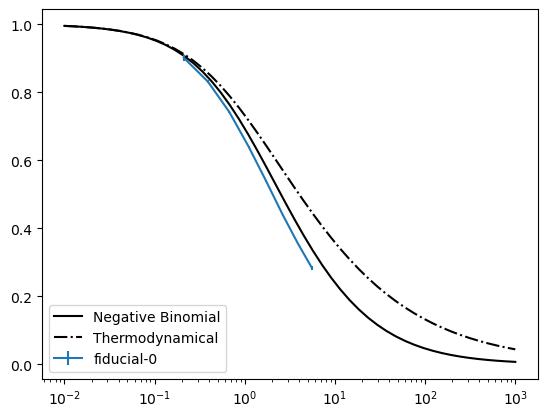

In [14]:
import matplotlib.pyplot as plt
from astropy.io import ascii

cosm = 'fiducial'
simnum = 0
ns = 10000
rbin = 8
rmin, rmax = 3., 25.
filename = f'../data/vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{simnum}.dat'

plotdata = ascii.read(filename)

x = np.geomspace(1E-2,1E3,50)
c='k'
plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')

nxi = plotdata['N_mean']*plotdata['xi']
chi = plotdata['chi']
chi_std = plotdata['chi_std']
plt.errorbar(N_mean*xi,chi,yerr=chi_std,c='C00',label=f'{cosm}-{simnum}')
plt.xscale('log')
plt.legend(loc=3)
plt.show()


